In [1]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

In [ ]:
#DO NOT RUN IF YOU DO NOT WANT TO GENERATE NEW DATA Loadinf of the main EP dataset
#data_path = './MindBigData-EP-v1.0/EP1.01.txt'
#split_main_data(data_path=data_path, output_folder='./MindBigData-EP-v1.0')

In [4]:
#DO NOT RUN IF YOU DO NOT WANT TO GENERATE NEW DATA Loadinf of the main Insight dataset
#data_path = './MindBigData-IN-v1.06/IN.txt'
#split_main_data(data_path=data_path, output_folder='./MindBigData-IN-v1.06', channel_count=5)

Load the files, get the points and the list of labels

In [ ]:
#files = glob.glob('./MindBigData-EP-v1.0/*.csv')
#all_points, all_labels = files_to_datapoints(epoc_files = files, first_n=len(files)) #first_n = 500 by default. Apply first_n = len(files) to load all

Same code but for also reading the insight data

In [6]:
files_insight = glob.glob('./MindBigData-IN-v1.06/*.csv')
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels, all_points_insight, all_labels_insight = files_to_datapoints(epoc_files = files, insight_files=files_insight, first_n=len(files)) #first_n = 500 by default. Apply first_n = len(files) to load all

Loading epoc data...


100%|██████████| 65034/65034 [03:00<00:00, 359.68it/s]


Loading insight data...


100%|██████████| 13050/13050 [01:32<00:00, 140.98it/s]


In [10]:
print("Num points EPOC:", len(all_points))
print("Num labels EPOC:", len(all_labels))
print("Labels EPOC:", all_labels)
print("------------------------------------")
print("Num points INSIGHT:", len(all_points_insight))
print("Num labels INSIGHT:", len(all_labels_insight))
print("Labels INSIGHT:", all_labels_insight)
print("------------------------------------")
print("Data shape EPOC", all_points[0].raw_data.shape)
print("Data shape INSIGHT", all_points_insight[0].raw_data.shape)

Num points EPOC: 64629
Num labels EPOC: 11
Labels EPOC: ['-1', '6', '7', '2', '0', '4', '5', '8', '9', '1', '3']
------------------------------------
Num points INSIGHT: 5400
Num labels INSIGHT: 10
Labels INSIGHT: ['6', '7', '2', '0', '4', '5', '8', '9', '1', '3']
------------------------------------
Data shape EPOC (256, 14)
Data shape INSIGHT (256, 5)


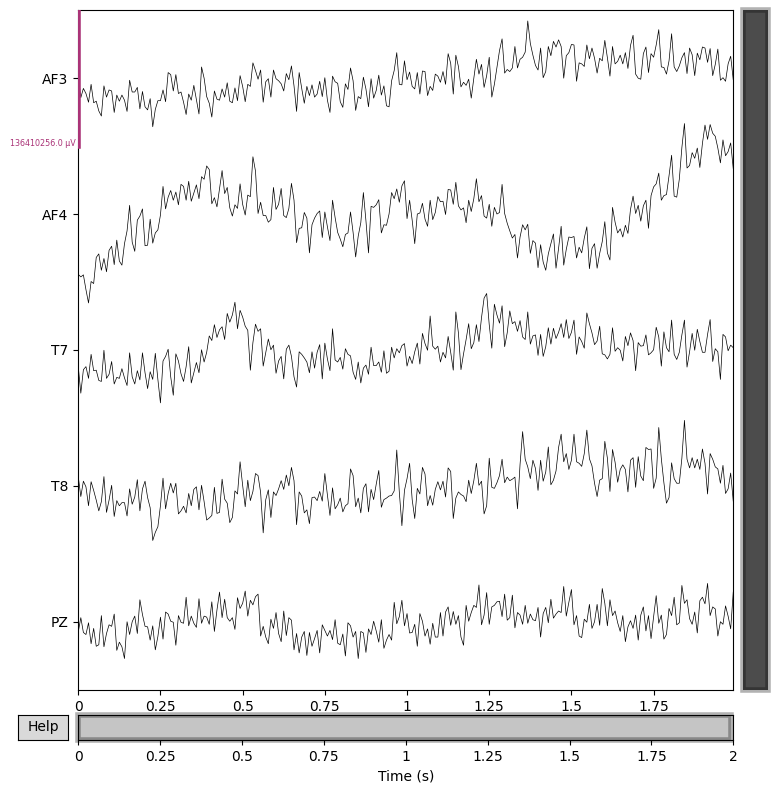

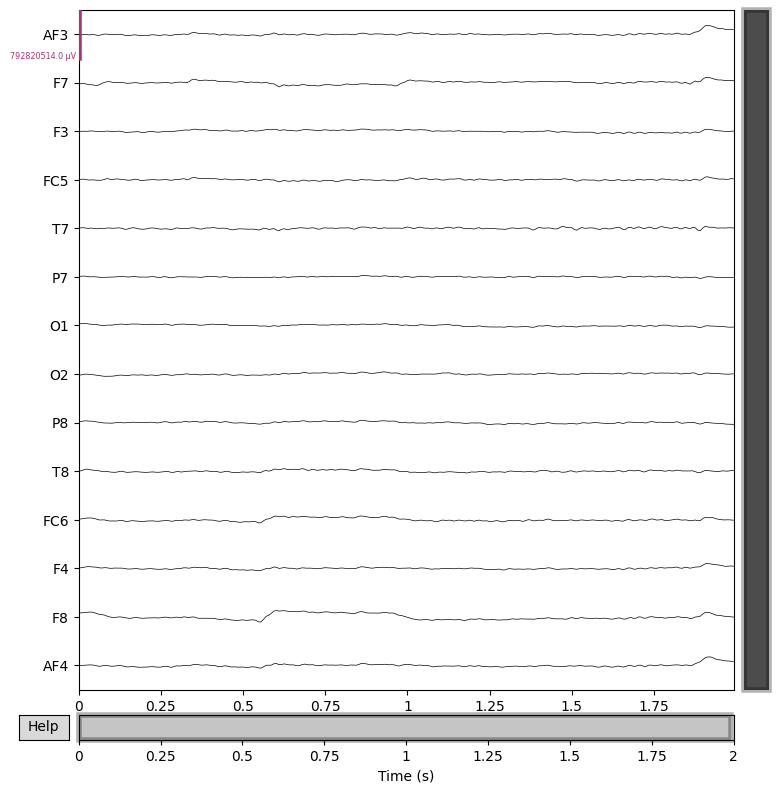

In [14]:
all_points_insight[0].mne_object.plot(scalings = 'auto'); #Pre-cleaning
all_points[0].mne_object.plot(scalings = 'auto');

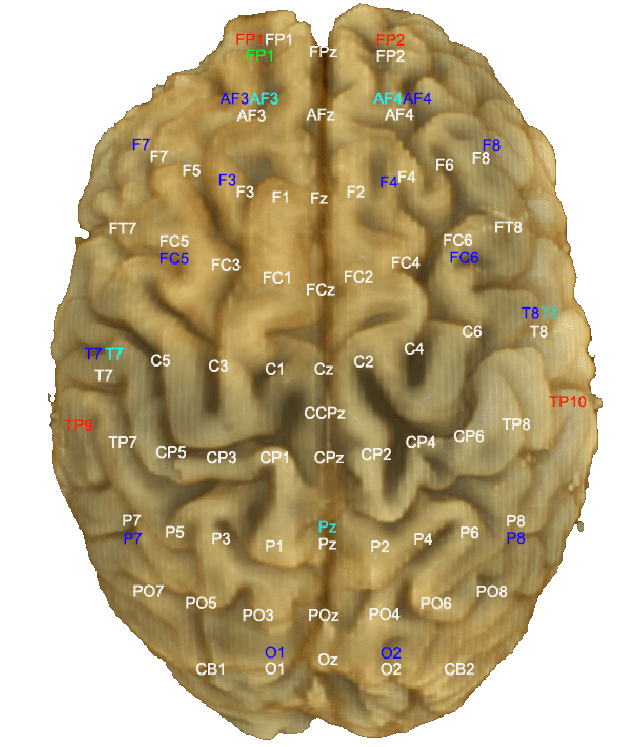

Epoc channels:---"AF3","AF4","T7","T8","P7", "F7", "F3", "FC5", "O1", "O2", "P8",  "FC6", "F4", "F8",

Insight channels: "AF3","AF4","T7","T8","PZ"

One paper states that best results came from 'T7', 'P7', 'P8', 'T8'

In [15]:
"""
We will loop through every data point and call the cleaning methods.
This filters the frequencies to be only between the ranges. We want 3 - 30 because this is where relevant alpha theta, beta bands lie.
MNE says to multiply the lowpass by 1/3.
"""
print("Cleaning epoc....")
for point in tqdm(all_points):
    """
    Full clean runs the following all at once, in this order.

    point.crop_to_channels(['T7', 'P7', 'P8', 'T8'])
    point.average_reference()
    point.filter_mne(3, 30)"""
    point.full_clean(channels = ["AF3","AF4","T7","T8"], l_freq = 3, h_freq = 30)

print("Cleaning insight....")
for point in tqdm(all_points_insight):
    point.full_clean(channels = ["AF3","AF4","T7","T8"], l_freq = 3, h_freq = 30)


100%|██████████| 5400/5400 [00:13<00:00, 411.74it/s]


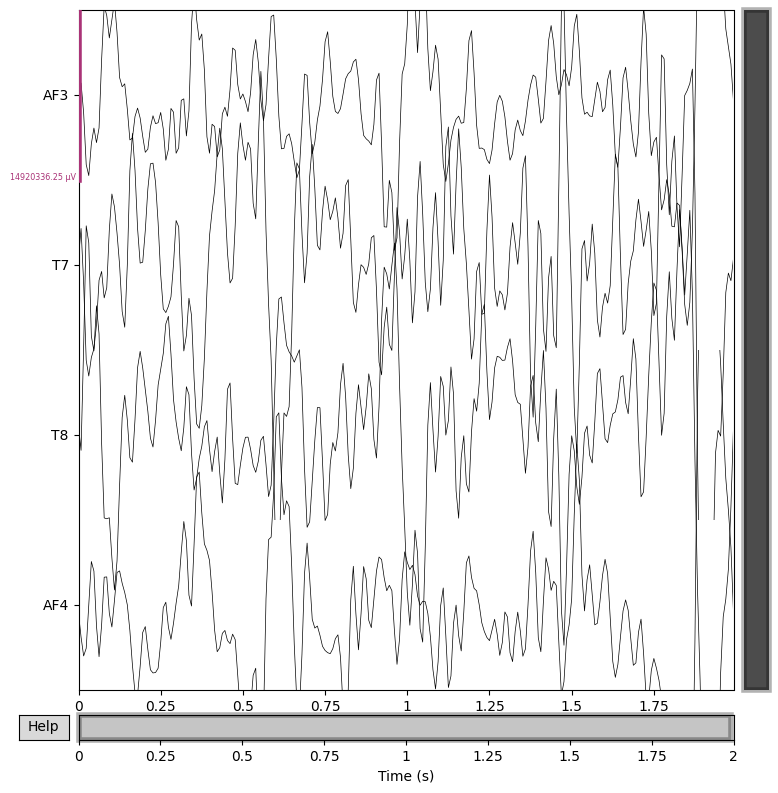

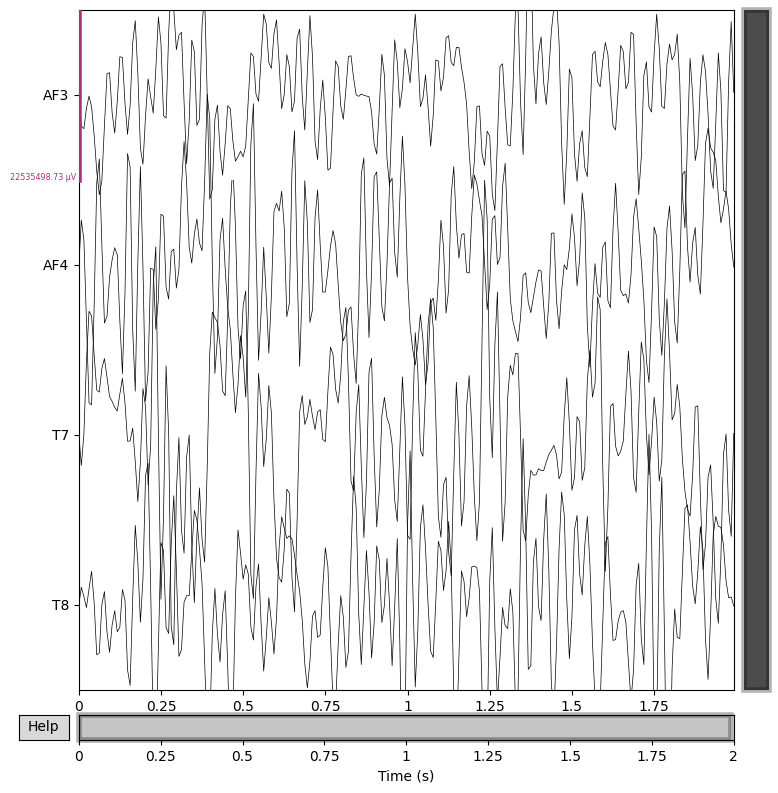

In [16]:
all_points[0].mne_object.plot(scalings='auto');
all_points_insight[0].mne_object.plot(scalings='auto');

Autoencoder with the goal of anomally detection.

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam, SGD
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
from Models.EegAutoencoder import Encoder, Decoder, Autoencoder
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
batch_size = 32
num_workers = 4

dataset = EegDataset(data_points=all_points, labels=all_labels)
train, test = train_test_split(dataset, train_size=0.8, shuffle=True)

train_dataloader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
input = next(train_dataloader.__iter__())[0]
input.shape

In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

latent_dim = 200

encoder = Encoder(latent_dim = latent_dim)
decoder = Decoder(latent_dim = latent_dim)

model = Autoencoder(decoder=decoder, encoder=encoder, device=device).to(device=device)

optimizer = Adam(model.parameters(), lr=0.0001)
loss_function = MSELoss()

n_epochs = 100

validation_data = []
training_data = []

for epoch in range(n_epochs):
    
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()
    train_loss = 0.0

    for data, label in tqdm(train_dataloader):
        
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = loss_function(output, data)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data
    
    train_loss/=(len(train_dataloader))
    training_data.append(train_loss.item())

    print('Epoch train Loss:', train_loss.item())
    print("Validating...")
    model.eval()
    val_loss = 0.0
    for data, label in test_dataloader:
        data = data.to(device)
        prediction = model(data)
        val_loss += loss_function(data, prediction)
    val_loss /= len(test_dataloader)
    validation_data.append(val_loss.item())
    print('Validation loss:',val_loss.item())

cuda
Epoch 1/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 107.0302505493164
Validating...
Validation loss: 96.1352310180664
Epoch 2/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 98.48729705810547
Validating...
Validation loss: 88.77213287353516
Epoch 3/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 91.70060729980469
Validating...
Validation loss: 84.781494140625
Epoch 4/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 87.98322296142578
Validating...
Validation loss: 83.1583023071289
Epoch 5/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 85.90202331542969
Validating...
Validation loss: 81.95187377929688
Epoch 6/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 84.04178619384766
Validating...
Validation loss: 79.48709869384766
Epoch 7/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 81.08980560302734
Validating...
Validation loss: 77.1994857788086
Epoch 8/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 76.51094818115234
Validating...
Validation loss: 72.95740509033203
Epoch 9/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 70.8571548461914
Validating...
Validation loss: 68.61859130859375
Epoch 10/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 68.17646026611328
Validating...
Validation loss: 68.19679260253906
Epoch 11/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 62.882896423339844
Validating...
Validation loss: 68.33800506591797
Epoch 12/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 61.83777618408203
Validating...
Validation loss: 63.01899719238281
Epoch 13/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 57.91638946533203
Validating...
Validation loss: 62.99757766723633
Epoch 14/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 56.3565788269043
Validating...
Validation loss: 62.51014709472656
Epoch 15/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 53.7787971496582
Validating...
Validation loss: 58.65869903564453
Epoch 16/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 52.95025634765625
Validating...
Validation loss: 56.92914962768555
Epoch 17/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 50.301239013671875
Validating...
Validation loss: 58.888240814208984
Epoch 18/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 49.39277648925781
Validating...
Validation loss: 59.399864196777344
Epoch 19/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 47.5810661315918
Validating...
Validation loss: 54.4890251159668
Epoch 20/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 46.58369064331055
Validating...
Validation loss: 54.32402038574219
Epoch 21/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 46.39478302001953
Validating...
Validation loss: 55.26178741455078
Epoch 22/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 44.96648406982422
Validating...
Validation loss: 54.18983459472656
Epoch 23/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 42.83121871948242
Validating...
Validation loss: 55.97944259643555
Epoch 24/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 43.16825866699219
Validating...
Validation loss: 55.202640533447266
Epoch 25/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 42.0839958190918
Validating...
Validation loss: 56.266754150390625
Epoch 26/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 41.03128433227539
Validating...
Validation loss: 55.25000762939453
Epoch 27/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 39.90549087524414
Validating...
Validation loss: 54.78089141845703
Epoch 28/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 39.738006591796875
Validating...
Validation loss: 55.0688362121582
Epoch 29/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 39.07695388793945
Validating...
Validation loss: 54.569950103759766
Epoch 30/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 38.20132827758789
Validating...
Validation loss: 55.132022857666016
Epoch 31/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 36.382781982421875
Validating...
Validation loss: 55.76034927368164
Epoch 32/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 36.68939208984375
Validating...
Validation loss: 57.368324279785156
Epoch 33/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 35.31650924682617
Validating...
Validation loss: 51.82951354980469
Epoch 34/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 34.852699279785156
Validating...
Validation loss: 54.072357177734375
Epoch 35/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 35.22930908203125
Validating...
Validation loss: 52.441097259521484
Epoch 36/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 33.652137756347656
Validating...
Validation loss: 52.062408447265625
Epoch 37/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 32.81003189086914
Validating...
Validation loss: 52.47582244873047
Epoch 38/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 33.592037200927734
Validating...
Validation loss: 52.122920989990234
Epoch 39/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 32.1071891784668
Validating...
Validation loss: 51.720001220703125
Epoch 40/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 31.25265884399414
Validating...
Validation loss: 53.20150375366211
Epoch 41/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 30.73335075378418
Validating...
Validation loss: 51.23219299316406
Epoch 42/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 30.981523513793945
Validating...
Validation loss: 50.32044219970703
Epoch 43/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 30.80864143371582
Validating...
Validation loss: 50.305084228515625
Epoch 44/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 30.10893440246582
Validating...
Validation loss: 51.35105514526367
Epoch 45/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 29.801450729370117
Validating...
Validation loss: 50.195194244384766
Epoch 46/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 29.439695358276367
Validating...
Validation loss: 52.78237533569336
Epoch 47/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 29.397846221923828
Validating...
Validation loss: 51.42475891113281
Epoch 48/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 29.10793113708496
Validating...
Validation loss: 48.84545135498047
Epoch 49/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 27.055097579956055
Validating...
Validation loss: 50.46998977661133
Epoch 50/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 28.374879837036133
Validating...
Validation loss: 50.60914993286133
Epoch 51/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 28.2710018157959
Validating...
Validation loss: 68.93773651123047
Epoch 52/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 28.989744186401367
Validating...
Validation loss: 49.462772369384766
Epoch 53/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 26.514848709106445
Validating...
Validation loss: 49.438568115234375
Epoch 54/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 26.083036422729492
Validating...
Validation loss: 49.87477493286133
Epoch 55/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 27.2131404876709
Validating...
Validation loss: 49.32049560546875
Epoch 56/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 26.01975440979004
Validating...
Validation loss: 61.1432991027832
Epoch 57/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 26.049785614013672
Validating...
Validation loss: 48.75994873046875
Epoch 58/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 26.858367919921875
Validating...
Validation loss: 49.90604782104492
Epoch 59/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 25.64338493347168
Validating...
Validation loss: 47.81476974487305
Epoch 60/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 24.145366668701172
Validating...
Validation loss: 48.029232025146484
Epoch 61/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 25.016033172607422
Validating...
Validation loss: 47.212520599365234
Epoch 62/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 25.445972442626953
Validating...
Validation loss: 47.636112213134766
Epoch 63/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 24.719341278076172
Validating...
Validation loss: 47.144065856933594
Epoch 64/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 24.08355140686035
Validating...
Validation loss: 47.45804214477539
Epoch 65/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 23.525697708129883
Validating...
Validation loss: 46.74775695800781
Epoch 66/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 23.984453201293945
Validating...
Validation loss: 47.6763801574707
Epoch 67/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 24.24741554260254
Validating...
Validation loss: 46.695491790771484
Epoch 68/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 23.8005313873291
Validating...
Validation loss: 48.981109619140625
Epoch 69/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 23.58820152282715
Validating...
Validation loss: 46.65594482421875
Epoch 70/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 24.213884353637695
Validating...
Validation loss: 46.103214263916016
Epoch 71/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 24.241682052612305
Validating...
Validation loss: 45.621551513671875
Epoch 72/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 22.08357810974121
Validating...
Validation loss: 46.493160247802734
Epoch 73/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 22.061561584472656
Validating...
Validation loss: 46.40391540527344
Epoch 74/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 22.731691360473633
Validating...
Validation loss: 54.52998733520508
Epoch 75/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 22.2971248626709
Validating...
Validation loss: 46.54969787597656
Epoch 76/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 22.25897979736328
Validating...
Validation loss: 45.24605941772461
Epoch 77/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 23.44856071472168
Validating...
Validation loss: 47.63324737548828
Epoch 78/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 22.06244659423828
Validating...
Validation loss: 44.45017623901367
Epoch 79/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 22.31184959411621
Validating...
Validation loss: 45.04864501953125
Epoch 80/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 21.457191467285156
Validating...
Validation loss: 47.527339935302734
Epoch 81/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 21.195693969726562
Validating...
Validation loss: 45.234256744384766
Epoch 82/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 20.8851261138916
Validating...
Validation loss: 44.70664978027344
Epoch 83/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 21.721210479736328
Validating...
Validation loss: 46.065269470214844
Epoch 84/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 23.517648696899414
Validating...
Validation loss: 46.28910446166992
Epoch 85/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 21.121309280395508
Validating...
Validation loss: 45.60523223876953
Epoch 86/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 19.89373207092285
Validating...
Validation loss: 45.67777633666992
Epoch 87/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 20.771318435668945
Validating...
Validation loss: 44.49228286743164
Epoch 88/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 21.25290870666504
Validating...
Validation loss: 44.78610610961914
Epoch 89/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 21.253841400146484
Validating...
Validation loss: 44.64228439331055
Epoch 90/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 20.824695587158203
Validating...
Validation loss: 51.0473518371582
Epoch 91/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 20.80217933654785
Validating...
Validation loss: 44.054359436035156
Epoch 92/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 19.563922882080078
Validating...
Validation loss: 44.1402473449707
Epoch 93/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 19.592601776123047
Validating...
Validation loss: 55.091060638427734
Epoch 94/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 20.667879104614258
Validating...
Validation loss: 43.219390869140625
Epoch 95/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 20.17772674560547
Validating...
Validation loss: 44.74250411987305
Epoch 96/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 19.623397827148438
Validating...
Validation loss: 43.013126373291016
Epoch 97/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 20.51778793334961
Validating...
Validation loss: 43.272666931152344
Epoch 98/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 19.175840377807617
Validating...
Validation loss: 43.32310485839844
Epoch 99/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 19.754661560058594
Validating...
Validation loss: 43.431495666503906
Epoch 100/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train Loss: 19.561933517456055
Validating...
Validation loss: 45.025718688964844


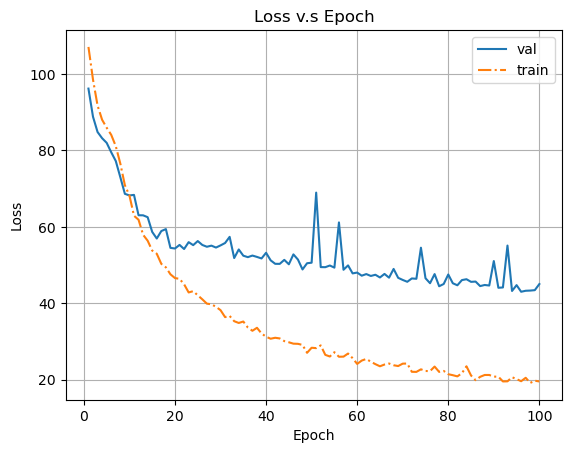

In [79]:
x = [i+1 for i in range(len(validation_data))]

plt.plot(x, validation_data, label ='val')
plt.plot(x, training_data, '-.', label ='train')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Loss v.s Epoch')
plt.grid()

plt.show()